In [1]:

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/KAN/SincKAN/')  # Add the directory to Python's path

from SincKANLayer import SincKANLayer



Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from SincKANLayer import SincKANLayer


In [3]:
# Define target function (piecewise function)
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    # add noise
    noise = np.random.normal(0, 0.1, y.shape)
    y_noise = y + noise

    return y, y_noise

In [10]:
# Define target function (sqrt(x))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0
    y[mask1] = 0
    mask2 = x >= 0
    y[mask2] = np.sqrt(x[mask2])


    # add noise
    noise = np.random.normal(0, 0.1, y.shape)
    y_noise = y + noise

    return y, y_noise

In [ ]:
# Define target function (x**0.5 * (1-x)**(3/4))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0
    y[mask1] = 0
    mask2 = (0 <= x) & (x <= 1)
    y[mask2] = x[mask2]**0.5 * (1-x[mask2])**(3/4)
    mask3 = x > 1
    y[mask3] = 0


    # add noise
    noise = np.random.normal(0, 0.1, y.shape)
    y_noise = y + noise

    return y, y_noise

In [15]:
# Define target function (exp(-x/0.01))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x >= 0
    y[mask1] = np.exp(-x[mask1]/0.01)




    # add noise
    noise = np.random.normal(0, 0.1, y.shape)
    y_noise = y + noise

    return y, y_noise

In [16]:
# Define MLP and SincKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x-1) # centralize the input


class SincKAN(nn.Module):
    def __init__(self):
        super(SincKAN, self).__init__()
        self.Sinckan1 = SincKANLayer(1, 8, 8)
        self.Sinckan2 = SincKANLayer(8, 1, 8)

    def forward(self, x):
        x = self.Sinckan1(x)
        x = self.Sinckan2(x)
        return x

In [17]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_target, y_train = target_function(x_train)
y_target, y_train = torch.tensor(y_target, dtype = torch.float32), torch.tensor(y_train, dtype = torch.float32)

# Instantiate models
Sinc_model = SincKAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_Sinc = torch.optim.Adam(Sinc_model.parameters(), lr=0.01)

optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.03)

Sinc_losses = []

mlp_losses = []


# Train the models
epochs = 20000
for epoch in range(epochs):
    optimizer_Sinc.zero_grad()
    outputs_Sinc = Sinc_model(x_train)
    loss_Sinc = criterion(outputs_Sinc, y_train)
    loss_Sinc_gen = criterion(outputs_Sinc, y_target)
    loss_Sinc.backward()
    optimizer_Sinc.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp_gen = criterion(outputs_mlp, y_target)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        Sinc_losses.append(loss_Sinc.item())

        mlp_losses.append(loss_mlp.item())

        print(f'Epoch {epoch + 1}/{epochs}, SincKAN training Loss: {loss_Sinc.item():.4e}, MLP training Loss: {loss_mlp.item():.4e}')
        print(f'Epoch {epoch + 1}/{epochs}, SincKAN generalization Loss: {loss_Sinc_gen.item():.4e}, MLP generalization Loss: {loss_mlp_gen.item():.4e}')
        print()
# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_Sinc = Sinc_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()


# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_Sinc = Sinc_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

# Access the value of self.h after training
trained_h1 = Sinc_model.Sinckan1.h.item()
trained_h2 = Sinc_model.Sinckan2.h.item()
print("Value of h in Sinckan1 after training:", trained_h1)
print("Value of h in Sinckan2 after training:", trained_h2)

Epoch 1/20000, SincKAN training Loss: 1.6383e-02, MLP training Loss: 5.5635e-02
Epoch 1/20000, SincKAN generalization Loss: 7.1289e-03, MLP generalization Loss: 4.6588e-02

Epoch 101/20000, SincKAN training Loss: 1.1592e-02, MLP training Loss: 1.2422e-02
Epoch 101/20000, SincKAN generalization Loss: 2.6816e-03, MLP generalization Loss: 3.2604e-03

Epoch 201/20000, SincKAN training Loss: 1.0613e-02, MLP training Loss: 1.2301e-02
Epoch 201/20000, SincKAN generalization Loss: 1.9415e-03, MLP generalization Loss: 3.2201e-03

Epoch 301/20000, SincKAN training Loss: 9.7680e-03, MLP training Loss: 1.2272e-02
Epoch 301/20000, SincKAN generalization Loss: 1.3236e-03, MLP generalization Loss: 3.1948e-03

Epoch 401/20000, SincKAN training Loss: 9.9964e-03, MLP training Loss: 1.2245e-02
Epoch 401/20000, SincKAN generalization Loss: 1.6272e-03, MLP generalization Loss: 3.1721e-03

Epoch 501/20000, SincKAN training Loss: 9.5659e-03, MLP training Loss: 1.2219e-02
Epoch 501/20000, SincKAN generalizati

AttributeError: 'ParameterList' object has no attribute 'item'

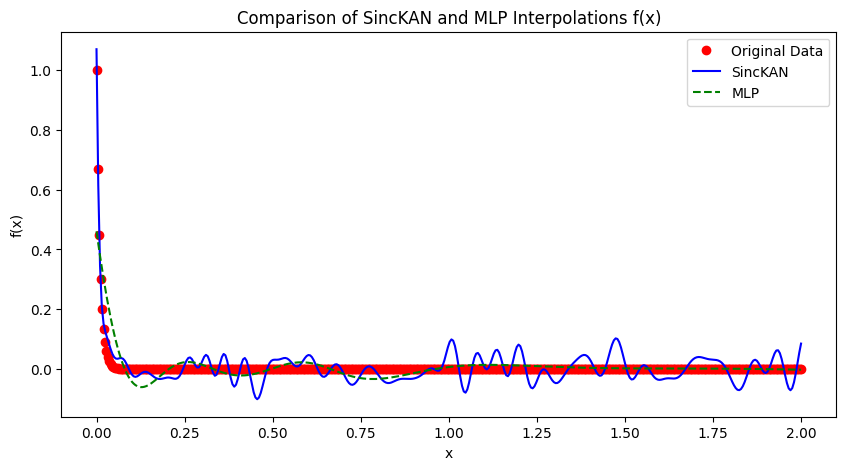

In [18]:
# Plot the results
plt.figure(figsize=(10, 5)) #更小的参数量更高的精度，epoch设到最大
plt.plot(x_train.numpy(), y_target.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_Sinc.numpy(), 'b-', label='SincKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of SincKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

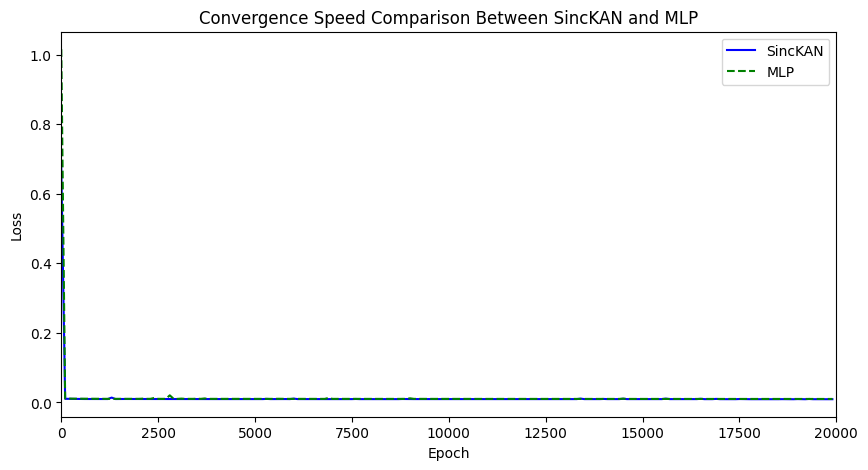

In [14]:
# Plot the convergence speed
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 100), Sinc_losses, 'b-', label='SincKAN')
plt.plot(range(0, epochs, 100), mlp_losses, 'g--', label='MLP')
plt.title('Convergence Speed Comparison Between SincKAN and MLP')
plt.xlim(0, 20000)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()